### My solution to the problem. I decided to extract the text from English Wikipedia page, break it down into words and sentences, eliminate common stopwords, and count the frequency of individual words and bigrams within sentences. After that, I use 10 most common words and bigrams to write a description to Wikipedia page. In the end, additionally I use some Transformed models to generate the description instead of creating it manually. 

In [1]:
# importing necessary packages
import pickle
import nltk
import requests
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
import torch

# importing the predefined list of stop-words
# it is the same as the one provided by in the original CodingTaskPython (1).ipynb notebook
with open('stopwords_MoBerries.pkl', 'rb') as f:
    stopwords_MoBerries = pickle.load(f)

# get the webpage
url = "https://en.wikipedia.org/wiki/Main_Page" 
page = requests.get(url)

# parsing the webpage
parsed_page = BeautifulSoup(page.content, "html.parser")

# extracting the text
page_text = parsed_page.get_text()

# tokenizing the text into sentences and words
nltk.download('punkt') # we need the "punkt" tokenizer for tokenizing text into individual words and sentences 
sentences = nltk.sent_tokenize(page_text)
words = nltk.word_tokenize(page_text)

# the list of stopwords
stopwords_MoBerries += ["..."] # I decided to add "..." as a stopword too
stopwords = set(stopwords_MoBerries)

# excluding stopwords from the list of words
filtered_words = [word.lower() for word in words if word.lower() not in stopwords]

# counting the number of words (it is crucial to use Counter to not count the same word multiple times)
word_counter = Counter(filtered_words)

# finidng bigrams in sentences and count their number
bigrams = []
for sentence in sentences:
    sentence_words = nltk.word_tokenize(sentence)
    filtered_sentence_words = [word.lower() for word in sentence_words if word.lower() not in stopwords]
    bigrams.extend(list(nltk.bigrams(filtered_sentence_words)))

# counting the number of bigrams 
bigram_counter = Counter(bigrams)

# most common (top10) words and bigrams
top_n = 10
common_words = word_counter.most_common(top_n)
common_bigrams = bigram_counter.most_common(top_n)
print(common_words)
print(common_bigrams)

[('wikipedia', 14), ('featured', 7), ('march', 6), ('main', 5), ('english', 5), ('articles', 5), ('article', 5), ('encyclopedia', 4), ('tools', 4), ('wikimedia', 4)]
[(('wikipedia', 'encyclopedia'), 3), (('march', '25'), 3), (('apollo', '13'), 3), (('main', 'menu'), 2), (('sidebar', 'hide'), 2), (('person', 'fly'), 2), (('archive', 'email'), 2), (('town', 'hall'), 2), (('25', 'march'), 2), (('nominate', 'article'), 2)]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


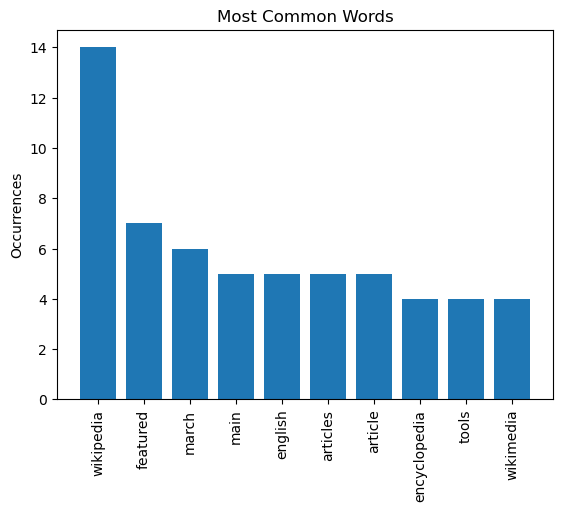

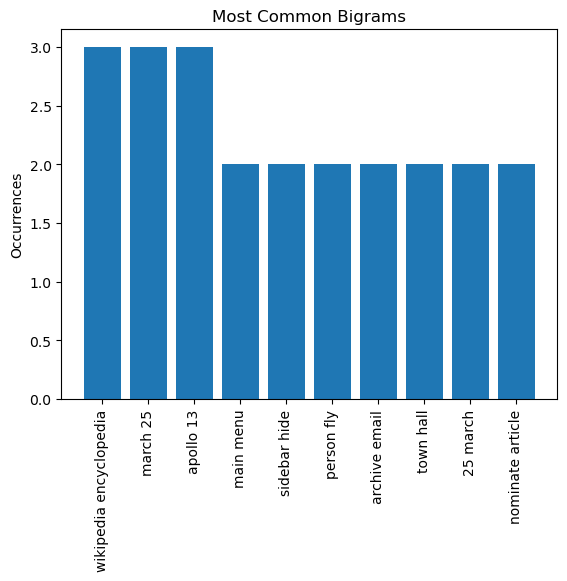

In [2]:
# Plot the most common words
plt.bar(range(top_n), [count for word, count in common_words], align="center")
plt.xticks(range(top_n), [word for word, count in common_words], rotation="vertical")
plt.ylabel("Occurrences")
plt.title("Most Common Words")
plt.show()

# Plot the most common bigrams
plt.bar(range(top_n), [count for bigram, count in common_bigrams], align="center")
plt.xticks(range(top_n), [f"{bigram[0]} {bigram[1]}" for bigram, count in common_bigrams], rotation="vertical")
plt.ylabel("Occurrences")
plt.title("Most Common Bigrams")
plt.show()

### Creating the description manually.

Using the most common words "['wikipedia', 'featured', 'march', 'main', 'english', 'articles', 'article', 'encyclopedia', 'tools', 'wikimedia']" and bigrams
"['wikipedia encyclopedia', 'march 25', 'apollo 13', 'main menu', 'sidebar hide', 'person fly', 'archive email', 'town hall', '25 march', 'nominate article']", a simple desciption of the webpage could be the following:

My description is - Wikipedia is an encyclopedia. It has articles in English.

### Generation of the desciption instead of creating it manually

In [3]:
# filtering out only the words
words_only = [item[0] for item in common_words]
print(words_only)
# filtering out only the bigrams (words separated by space)
bigrams_only = ["{} {}".format(item[0][0], item[0][1]) for item in common_bigrams]
print(bigrams_only)

['wikipedia', 'featured', 'march', 'main', 'english', 'articles', 'article', 'encyclopedia', 'tools', 'wikimedia']
['wikipedia encyclopedia', 'march 25', 'apollo 13', 'main menu', 'sidebar hide', 'person fly', 'archive email', 'town hall', '25 march', 'nominate article']


### I tested first keytotext

In [4]:
from keytotext import pipeline
 
# Loading the pretrained T5 model
nlp = pipeline("k2t-base")
 
# the models parameters
config = {"do_sample": True, "num_beams": 4, "no_repeat_ngram_size": 3, "early_stopping": True, "max_new_tokens": 20}
 
# I decided to use only the first 5 words
print("The generated description is: ", nlp(words_only[:5], **config))

Global seed set to 42


The generated description is:  The main ingredient of wikipedia is english.


### Then I decided to try gpt2

In [5]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# joining the words - this is important, otherwise the model doesn't differenciate semantically the words
input_text = ', '.join(words_only)

question = f"Create a coherent description using all of the following words: {input_text}:"
indexes = tokenizer.encode(question, return_tensors="pt")

# setting pad_token_id to eos_token_id
tokenizer.pad_token = tokenizer.eos_token

# creating attention_mask manually
attention_mask = torch.ones(indexes.shape, dtype=torch.long)

output = model.generate(indexes, max_length=80, num_return_sequences=1, temperature=0.8, no_repeat_ngram_size=2, attention_mask = attention_mask)
generated_sentence = tokenizer.decode(output[0], skip_special_tokens=True).replace(question, '')

# printing the generated sentence
print("The generated description is: ", generated_sentence.strip())


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The generated description is:  Wikipedia is a wiki. It is the most popular and most widely used encyclopedia in the world. Wikipedia is an open source encyclopedia. The wiki is open to all.
. Wikis are a collection of articles that are written


### In conclusion, regarding the generation of descriptions, I think the most valuable ones come from humans (not to boast about my own abilities, but merely to compare human and machine-generated descriptions) and those created by GPT-2. My description is brief, offering a concise two-sentence summary of the webpage, while GPT-2 provides a more detailed, albeit somewhat longer, version. The description generated by Keytotext contains the word "ingredient," which appears to be out of context in this particular case.